Visualization of the impact of every pixel on the score of the correct class, based on the paper from Simonyan et al. (2014). "Visualising image classification models and saliency maps".

In [1]:
import torch
import torchvision
from torchvision import transforms
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch.autograd import grad

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'viridis'

We will use the Squeezenet model which is a light model pre-trained on ImageNet. Why a light model? because we will need to calculate a lot of gradients and I don't have enough resources and time for that 

In [2]:
model = torchvision.models.squeezenet1_1(pretrained=True)
model.eval()
for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


  0%|          | 0.00/4.73M [00:00<?, ?B/s]

In [3]:
!wget https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky -O images.npz

--2022-03-19 00:45:05--  https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky
Resolving drive.google.com (drive.google.com)... 142.250.152.102, 142.250.152.101, 142.250.152.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.152.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky/ [following]
--2022-03-19 00:45:05--  https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky/
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky/edit [following]
--2022-03-19 00:45:05--  https://drive.google.com/file/d/1qig37g-YRo9tn60vr6BhhfSA3UWJr1Ky/edit
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘images.npz’

images.npz      

We load 25 examples from ImageNet for our experimentations. 

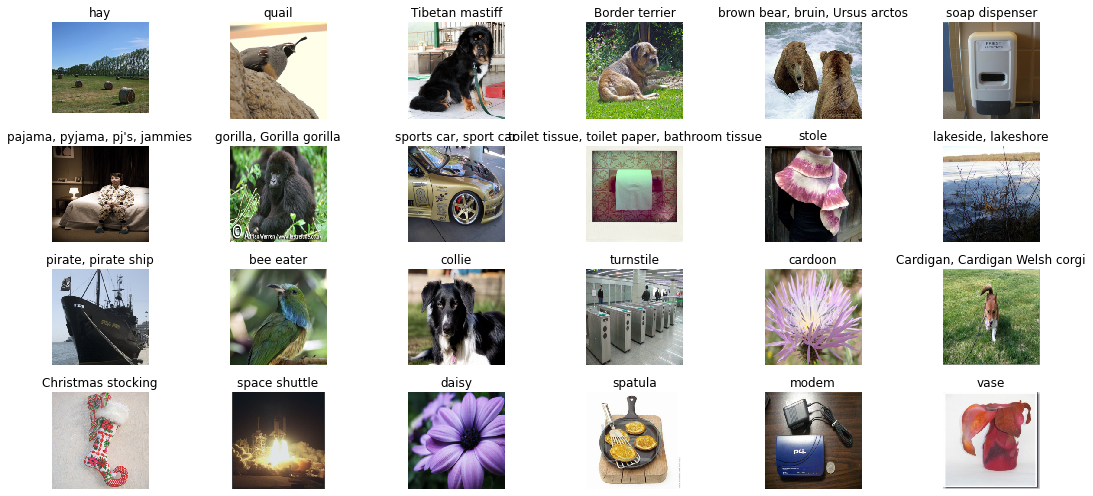

In [5]:
f = np.load("images.npz", allow_pickle=True)
X, y, class_names = f["X"], f["y"], f["label_map"].item()
class_names_to_id = {name: id for id, name in class_names.items()}

plt.figure(figsize=(15, 7))
for i in range(24):
    plt.subplot(4, 6, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

In [10]:
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def preprocess(img, size=224):
    transform = transforms.Compose([
        transforms.Scale(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        transforms.Lambda(lambda x: x[None]),  # add one dimension
    ])
    return transform(img)

A saliency map is a map which indicates the important zones of an image. In our case, this corresponds to the most impactful pixels for predicting the correct class. To produce these maps, the authors of the paper propose to approximate the neural network f in the neighborhood of an image x of class i by a linear function.


$ y_i = f_i(x) ≈ w^T_i x + b$ 

with $w_i = \frac{ ∂\hat{y_i} }{∂x}  $

In [8]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    X.requires_grad = True
    saliency = None
    res = model.forward(X)
    w = []
    for i,j in enumerate(y):
      a=grad(res[i][j],X,retain_graph=True)[0]
      w.append(a[i])
    w=torch.stack(w)
    X=w*X
    saliency=torch.max(X,1).values
    return saliency.detach()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


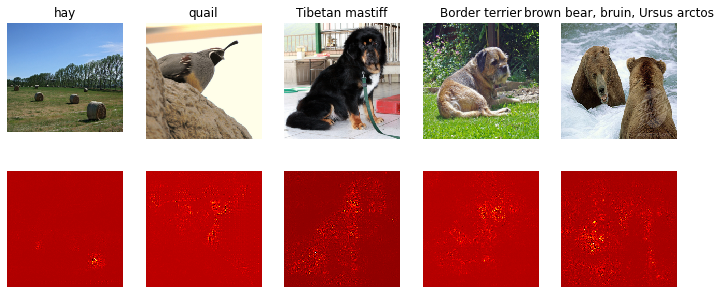

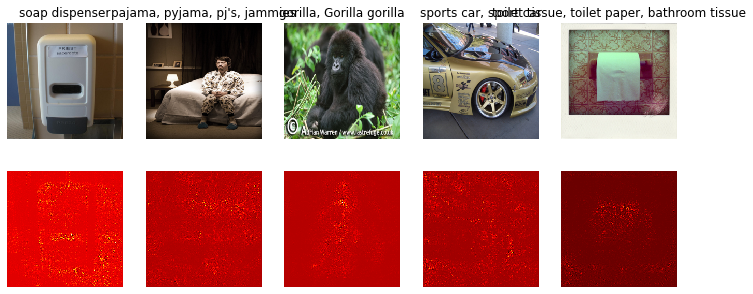

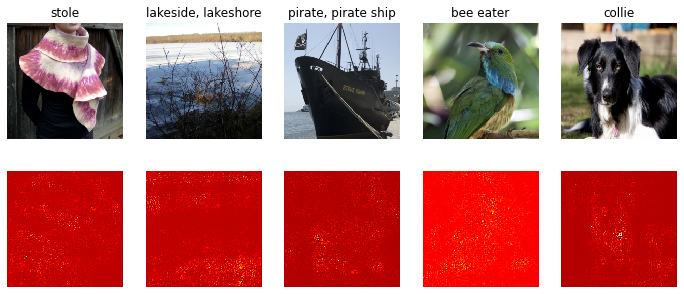

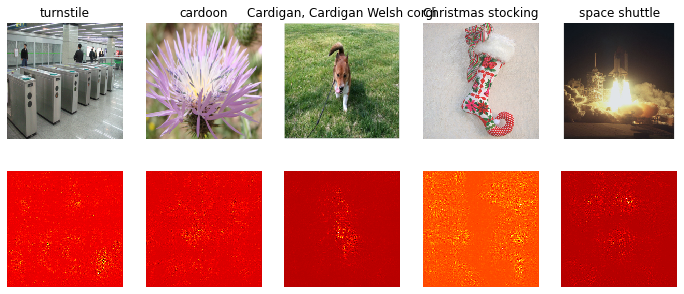

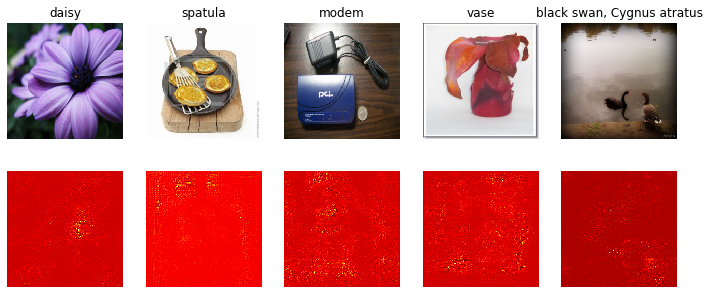

In [9]:
def show_saliency_maps(X, y, model):
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

for i in range(5): 
    show_saliency_maps(X[5*i:5*i+5], y[5*i:5*i+5], model)